## Contact map for lactoferrin dimer

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import mdtraj as md
from math import sqrt, pi
import os.path, os, sys, json, filecmp, copy
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir
print(workdir)

/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom


In [2]:
traj = md.open('ab.pdb')
top = traj.topology
traj.distance_unit

'angstroms'

In [3]:
def masscenter(atoms, positions):
    cm = [0,0,0] # residue mass center
    mw = 0       # residue weight
    for a in atoms:
        cm = cm + a.element.mass * positions[0][a.index]
        mw = mw + a.element.mass
    return cm / mw

In [4]:
d1 = []
d2 = []
chain1 = top.chain(0)
chain2 = top.chain(1)
for res1 in chain1.residues:
    cm1 = masscenter(res1.atoms, traj.positions)
    for res2 in chain2.residues:
        cm2 = masscenter(res2.atoms, traj.positions)
        r2 = np.linalg.norm(cm1-cm2)
        if (r2<5.0**2):
            d2.append( [res1.index+1, res2.index-chain1.n_residues+1, r2] )
            if (r2<3.0**2):
                d1.append( [res1.index+1, res2.index-chain1.n_residues+1, r2] )
                #print(res1.name + str(res1.index+1), res2.name+str(res2.index-chain1.n_residues+1), sqrt(r2))
        
d1[2]=np.sqrt(d1[2])
d2[2]=np.sqrt(d2[2])
d1=np.array(d1).T
d2=np.array(d2).T

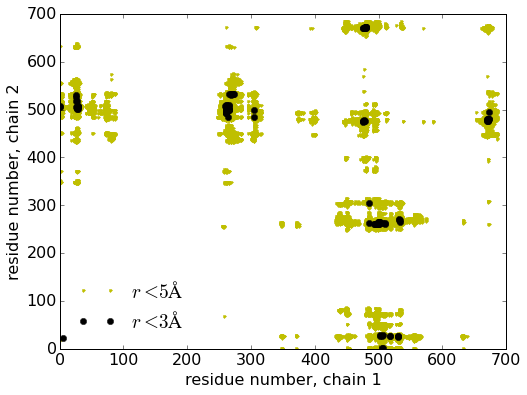

In [5]:
plt.plot(d2[0], d2[1], 'y.', label=r'$r < 5 {\AA}$')
plt.plot(d1[0], d1[1], 'ko', label=r'$r < 3 {\AA}$')
plt.legend(loc=0, frameon=False)
plt.xlabel('residue number, chain 1')
plt.ylabel('residue number, chain 2')

## Titration of dimeric structure

In [67]:
%%bash -s "$workdir"
%cd $1

if [ ! -d "faunus/" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    #git checkout a2220dc8f98606d2ceb42f14c6a08ec0723d8787
else
    cd faunus
fi

# if different, copy custom titrate.cpp into faunus
if ! cmp ../titrate.cpp src/examples/gctit.cpp
then
    cp ../titrate.cpp src/examples/gctit.cpp
fi
pwd
cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on &>/dev/null
make example_gctit -j4
%cd $1

/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom/faunus
[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target example_gctit


bash: line 1: fg: no job control
bash: line 19: fg: no job control


In [68]:
%%writefile submit.sh
#!/bin/bash
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 02:00:00
../faunus/src/examples/gctit > out

Writing submit.sh


In [69]:
pH_range       = np.arange(1, 14, 0.2)
salt_range     = [0.035, 0.2]
print(pH_range)

[  1.    1.2   1.4   1.6   1.8   2.    2.2   2.4   2.6   2.8   3.    3.2
   3.4   3.6   3.8   4.    4.2   4.4   4.6   4.8   5.    5.2   5.4   5.6
   5.8   6.    6.2   6.4   6.6   6.8   7.    7.2   7.4   7.6   7.8   8.
   8.2   8.4   8.6   8.8   9.    9.2   9.4   9.6   9.8  10.   10.2  10.4
  10.6  10.8  11.   11.2  11.4  11.6  11.8  12.   12.2  12.4  12.6  12.8
  13.   13.2  13.4  13.6  13.8]


In [34]:
%cd $workdir

def mkinput():
    js = {
        "energy": {
            "eqstate": { "processfile": "titrate.json" },
            "nonbonded": {
                "coulomb": { "epsr": 80 }
            }
        },

        "system": {
            "temperature": 298.15,
            "sphere" : { "radius" : 90 },
            "mcloop": { "macro": 10, "micro": micro }
        },

        "moves": {
            "gctit"         : { "molecule": "salt", "prob": 0.5 },
            "atomtranslate" : {
                "salt":  { "prob": 0.5 }
            }
        },

        "moleculelist": {
            "protein":  { "structure":"../dimer.pqr", "Ninit":1, "insdir":"0 0 0"},
            "salt": {"atoms":"Na Cl", "Ninit":60, "atomic":True }
        },
        
        "analysis": {
            "chargemultipole" : { "nstep":2, "mollist" : ["protein"] }
        },

        "atomlist" : {
            "Na"   :  { "q": 1, "r":1.9, "eps":0.005, "mw":22.99, "dp":100, "activity":salt },
            "Cl"   :  { "q":-1, "r":1.7, "eps":0.005, "mw":35.45, "dp":100, "activity":salt },
            "ASP"  :  { "q":-1, "r":3.6, "eps":0.05, "mw":110 },
            "HASP" :  { "q":0,  "r":3.6, "eps":0.05, "mw":110 },
            "LASP" :  { "q":2,  "r":3.6, "eps":0.05, "mw":110 },
            "CTR"  :  { "q":-1, "r":2.0, "eps":0.05, "mw":16 },
            "HCTR" :  { "q":0,  "r":2.0, "eps":0.05, "mw":16 },
            "GLU"  :  { "q":-1, "r":3.8, "eps":0.05, "mw":122 },
            "HGLU" :  { "q":0,  "r":3.8, "eps":0.05, "mw":122 },
            "LGLU" :  { "q":2,  "r":3.8, "eps":0.05, "mw":122 },
            "HIS"  :  { "q":0,  "r":3.9, "eps":0.05, "mw":130 },
            "HHIS" :  { "q":1,  "r":3.9, "eps":0.05, "mw":130 },
            "NTR"  :  { "q":0,  "r":2.0, "eps":0.05, "mw":14 },
            "HNTR" :  { "q":1,  "r":2.0, "eps":0.05, "mw":14 },
            "TYR"  :  { "q":-1, "r":4.1, "eps":0.05, "mw":154 },
            "HTYR" :  { "q":0,  "r":4.1, "eps":0.05, "mw":154 },
            "LYS"  :  { "q":0,  "r":3.7, "eps":0.05, "mw":116 },
            "HLYS" :  { "q":1,  "r":3.7, "eps":0.05, "mw":116 },
            "CYb"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":103 },
            "CYS"  :  { "q":-1, "r":3.6, "eps":0.05, "mw":103 },
            "HCYS" :  { "q":0,  "r":3.6, "eps":0.05, "mw":103 },
            "ARG"  :  { "q":0,  "r":4.0, "eps":0.05, "mw":144 },
            "HARG" :  { "q":1,  "r":4.0, "eps":0.05, "mw":144 },
            "ALA"  :  { "q":0,  "r":3.1, "eps":0.05, "mw":66 },
            "ILE"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":102 },
            "LEU"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":102 },
            "MET"  :  { "q":0,  "r":3.8, "eps":0.05, "mw":122 },
            "PHE"  :  { "q":0,  "r":3.9, "eps":0.05, "mw":138 },
            "PRO"  :  { "q":0,  "r":3.4, "eps":0.05, "mw":90 },
            "TRP"  :  { "q":0,  "r":4.3, "eps":0.05, "mw":176 },
            "VAL"  :  { "q":0,  "r":3.4, "eps":0.05, "mw":90 },
            "SER"  :  { "q":0,  "r":3.3, "eps":0.05, "mw":82 },
            "THR"  :  { "q":0,  "r":3.5, "eps":0.05, "mw":94 },
            "ASN"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":108 },
            "GLN"  :  { "q":0,  "r":3.8, "eps":0.05, "mw":120 },
            "GLY"  :  { "q":0,  "r":2.9, "eps":0.05, "mw":54 }
        },

        "processes" : {
            "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
            "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
            "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
            "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
            "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
            "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
            "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
            "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
            "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH }
        }
    }

    with open('titrate.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

for salt in salt_range:
    for pH in pH_range:
        pfx='pH'+str(pH)+'-I'+str(salt)
        if not os.path.isdir(pfx):
            %mkdir -p $pfx
            %cd $pfx

            # equilibration run (no translation)
            !rm -fR state
            micro=5000
            mkinput()
            !../faunus/src/examples/gctit > eq 2>&1

            # production run
            micro=50000
            mkinput()
            sbatch ../submit.sh
            
            %cd -q ..

print('done.')

/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom/pH1.0-I0.035
State file not found.
CPU times: user 80.7 ms, sys: 34.4 ms, total: 115 ms
Wall time: 13.3 s
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom/pH1.2-I0.035
State file not found.
CPU times: user 81.7 ms, sys: 34.5 ms, total: 116 ms
Wall time: 13.4 s
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom/pH1.4-I0.035
State file not found.
CPU times: user 97.3 ms, sys: 38.5 ms, total: 136 ms
Wall time: 13.7 s
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom/pH1.6-I0.035
State file not found.
CPU times: user 98.9 ms, sys: 39.1 ms, total: 138 ms
Wall time: 13.8 s
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom
/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom/pH1.8-I0.035
State file not found.
C

## Charge analysis of dimer

In [62]:
%cd $workdir
import json

data = {}

for salt in salt_range:
    d = {}
    d['pH'] = pH_range
    d['Z'] = []
    d['C'] = []
    for pH in pH_range:
        pfx='pH'+str(pH)+'-I'+str(salt)
        if os.path.isdir(pfx):
            %cd -q $pfx            
            results = json.load( open('analysis_out.json') )
            j  = results['chargemultipole']['mollist']['protein']
            Z  = j['Z']
            Z2 = j['Z2']
            d['Z'].append(Z)
            d['C'].append(Z2-Z*Z)
            %cd -q ..
    data[str(salt)] = d

data = pd.DataFrame(data) # convert to pandas object
data

/Users/mikael/Box Sync/linda/lactoferrin-CG-2-allatom


,0.035,0.2
C,"[9.62815056839, 11.7884386416, 12.3531066187, ...","[5.88955519038, 6.04903866174, 7.50492618841, ..."
Z,"[195.982296, 189.36172, 182.930708, 176.559324...","[206.703796, 203.846516, 199.99454, 197.485936..."
pH,"[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, ...","[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, ..."


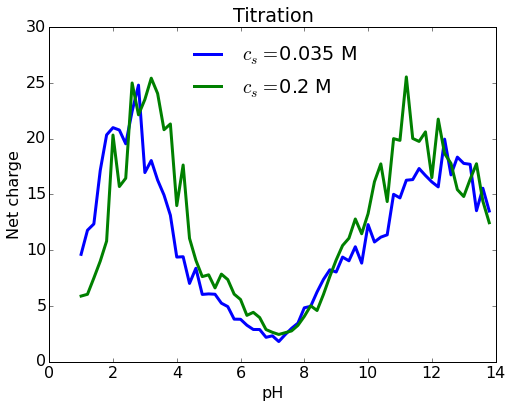

In [65]:
plt.title('Titration')
plt.xlabel('pH')
plt.ylabel('Net charge')
for salt, d in data.iteritems():
    plt.plot(d.pH, d.C, label=r'$c_s=$'+salt+' M', lw=3)
plt.legend(loc=0, frameon=False)